### Packages

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import os
from PIL import Image
from scipy import ndimage


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### Loading and preprocessing of the dataset

In [2]:
# Step 1: Load and preprocess the CIFAR-10 dataset

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Step 1.1: Load and preprocess the dataset

dataset_folder = '/Users/ryanvitalez/Desktop/cifar-10-batches-py'
data_dict = {}

# Step 1.2: Iterate through each batch file in the folder

for file in os.listdir(dataset_folder):
    if file.startswith("data_batch"):
        batch_path = os.path.join(dataset_folder, file)
        batch_dict = unpickle(batch_path)
        
        # Merge the data from each batch into a single dictionary
        
        if not data_dict:
            data_dict = batch_dict
        else:
            for key in data_dict:
                data_dict[key] += batch_dict[key]

train_images = data_dict[b'data']
train_labels = data_dict[b'labels']

# Step 1.3: Normalize the pixel values

train_images = train_images / 255.0

# Step 1.4: Split the dataset into training and validation sets

val_split = 0.2
num_samples = train_images.shape[0]
num_val_samples = int(num_samples * val_split)

val_images = train_images[:num_val_samples]
val_labels = train_labels[:num_val_samples]
train_images = train_images[num_val_samples:]
train_labels = train_labels[num_val_samples:]


### dnn_utils_v2

In [3]:
# since dnn_utils_v2 do not work for me:

def sigmoid(Z):
    
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- return Z as well, useful during back propagation
    """
    
    A = 1/(1 + np.exp(-Z))
    cache = Z
    
    return A, cache

In [4]:
def relu(Z):
    
    """
    Implement the ReLU function.
    
    Arguments:
    Z -- output of the linear layer, of any shape
    
    Returns: 
    A -- post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    
    """
    
    A = np.maximum(0, Z)
    
    assert(A.shape == Z.shape)
    
    return A, cache


In [5]:
def relu_backward(dA, Z):
    
    """
    Implement the backward propagation for a single ReLU unit.
    
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    
    Returns:
    dZ -- gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True)
    
    # When Z <= 0, set dZ to 0
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    return dZ

In [6]:
def sigmoid_backward(dA, cache):
    
    """
    Implement the backward propagation for a single SIGMOID unit
    
    Arugments: 
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    
    Returns:
    dZ -- gradient of the cost with respect to Z
    
    """
    
    Z = cache
    
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    assert(dZ.shape == Z.shape)
    
    return dZ


In [7]:
def load_data():
    train_set = unpickle('/Users/ryanvitalez/Desktop/cifar-10-batches-py/data_batch_1')
    test_set = unpickle('/Users/ryanvitalez/Desktop/cifar-10-batches-py/test_batch')
    
    train_set_x_orig = train_set[b'data']
    train_set_y_orig = np.array(train_set[b'labels'])
    test_set_x_orig = test_set[b'data']
    test_set_y_orig = np.array(test_set[b'labels'])
    
    classes = unpickle('/Users/ryanvitalez/Desktop/cifar-10-batches-py/batches.meta')[b'label_names']
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [8]:
def initialize_parameters(n_x, n_h1, n_h2, n_h3, n_y):
    
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    Parameters -- python dictionary containing the following parameters:
                    W1 -- weight matrix of shape (n_h1, n_x)
                    b1 -- bias vector of shape (n_h1, 1)
                    W2 -- weight matrix of shape (n_h2, n_h1)
                    b2 -- bias vector of shape (n_h2, 1)
                    W3 -- weight matrix of shape (n_h3, n_h2)
                    b3 -- bias vector of shape (n_h3, 1)
                    W4 -- weight matrix of shape (n_y, n_h3)
                    b4 -- bias vector of shape (n_y, 1)
    """
    
#    np.random.seed(a)
    
    W1 = np.random.randn(n_h1, n_x) * 0.01
    b1 = np.zeros(shape=(n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * 0.01
    b2 = np.zeros(shape=(n_h2, 1))
    W3 = np.random.randn(n_h3, n_h2) * 0.01
    b3 = np.zeros(shape=(n_h3, 1))
    W4 = np.random.randn(n_y, n_h3) * 0.01
    b4 = np.zeros(shape=(n_y, 1))
    
    assert(W1.shape == (n_h1, n_x))
    assert(b1.shape == (n_h1, 1))
    assert(W2.shape == (n_h2, n_h1))
    assert(b2.shape == (n_h2, 1))
    assert(W3.shape == (n_h3, n_h2))
    assert(b3.shape == (n_h3, 1))
    assert(W4.shape == (n_y, n_h3))
    assert(b4.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4}
    
    return parameters

In [9]:
def initialize_parameters_deep(layer_dims):
    
    """
    Argument:
    layer_dims -- python array (list) containing the dimenstions of each layer in the network
    
    Returns:
    Parameters -- python dictionary containing the parameters "W1", "b1", ... , "WL", "bL":
                    Wl -- wight matrix of shape (layer_dims[l], layer_dims[l - 1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l - 1]) 
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [10]:
def linear_forward(A, W, b):
    
    """
    Implement the linear part of a layer's forward propagation
    
    Arguments:
    A -- activation from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix; numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector; numpy array of shape (size of the current layer, 1)
    
    Returns:
    Z -- the input of the activation function, also call pre-activation parameter
    cache -- a python dictionary containing "A", "W", and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache == (A, W, b)
    
    return Z, cache


In [11]:
def linear_activation_forward(A_prev, W, b, activation):
    
    """
    Implement the forward propagation for the LINEAR -> ACTIVATION layer
    
    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation function to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    A -- the output of the activation function, also called the post-activation value
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             store for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z) 
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [12]:
def L_model_forward(X, parameters):
    
    """
    Implement forward propagation for the (LINEAR -> RELU) * (L-1) - > LINEAR -> SIGMOID computation
    
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_dee()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    
    caches = []
    A = X
    L = len(parameters) // 2
    
    # Implement [LINEAR -> RELU] * (L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement [LINEAR -> SIGMOID] * (L-1). Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(l)], parameters['b' + str(l)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

In [13]:
def compute_cost(AL, Y):
    
    """
    Implement the cost function
    
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    
    Returns: 
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    
    cost = (1./m) * (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

In [14]:
def linear_backward(dZ, cache):
    
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    assert(dA_prev.shape == A_prev.shape)
    assert(db.shape == b.shape)
    assert(dW.shape == W.shape)
    
    return dA_prev, dW, db

In [15]:
def linear_activation_backward(dA, cache, activation):
    
    """
    Implement the backward propagation for the LINEAR -> ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [16]:
def L_model_backward(AL, Y, caches):
    
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    
    grads = {} 
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L - 1)):
        current_cache = cache[l]
        dA_prev, dW_temp, db_temp = linear_activation_backwards(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        
        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    # Computation of the final layer's gradient
    
    L = len(caches)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L - 1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    gradients["dA" + str(L)] = dA_prev_temp
    gradients["dW" + str(L)] = dW_temp
    gradients["db" + str(L)] = db_temp

    return grads

In [17]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [18]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1, m))
    
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, 1] = 0
            
    print("Accuracy: " + str(np.sum((p == y)/m)))
    
    return p

In [19]:
def print_mislabeled_images(dataset_folder, X, classes, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    
    X = {dataset_folder}
    a = p + y
    mislabeled_indices = np.asaaray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) 
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[index].reshape(64, 64, 3). interpolation == 'nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0, index])].decode("utf-8") + "\n Class:" + classes[y[0, index]].decode("utf-8"))
                  

In [20]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_data()

### Initialization

#### 4-Layer Neural Network

In [21]:
def initialize_parameters(n_x, n_h1, n_h2, n_h3, n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h1, n_x) * 0.01
    b1 = np.zeros(shape=(n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * 0.01
    b2 = np.zeros(shape=(n_h2, 1))
    W3 = np.random.randn(n_h3, n_h2) * 0.01
    b3 = np.zeros(shape=(n_h3, 1))
    W4 = np.random.randn(n_y, n_h3) * 0.01
    b4 = np.zeros(shape=(n_y, 1))
    
    assert(W1.shape == (n_h1, n_x))
    assert(b1.shape == (n_h1, 1))
    assert(W2.shape == (n_h2, n_h1))
    assert(b2.shape == (n_h2, 1))
    assert(W3.shape == (n_h3, n_h2))
    assert(b3.shape == (n_h3, 1))
    assert(W4.shape == (n_y, n_h3))
    assert(b4.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4}
    
    return parameters

In [22]:
parameters = initialize_parameters(5,4,3,2,1)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("W3 = " + str(parameters["W3"]))
print("b3 = " + str(parameters["b3"]))
print("W4 = " + str(parameters["W4"]))
print("b4 = " + str(parameters["b4"]))


W1 = [[ 0.01624345 -0.00611756 -0.00528172 -0.01072969  0.00865408]
 [-0.02301539  0.01744812 -0.00761207  0.00319039 -0.0024937 ]
 [ 0.01462108 -0.02060141 -0.00322417 -0.00384054  0.01133769]
 [-0.01099891 -0.00172428 -0.00877858  0.00042214  0.00582815]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01100619  0.01144724  0.00901591  0.00502494]
 [ 0.00900856 -0.00683728 -0.0012289  -0.00935769]
 [-0.00267888  0.00530355 -0.00691661 -0.00396754]]
b2 = [[0.]
 [0.]
 [0.]]
W3 = [[-0.00687173 -0.00845206 -0.00671246]
 [-0.00012665 -0.0111731   0.00234416]]
b3 = [[0.]
 [0.]]
W4 = [[0.01659802 0.00742044]]
b4 = [[0.]]


#### L-Layer Neural Network

In [23]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(5)
    
    parameters = {}
    L = len(layer_dims)    # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros(shape=(layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [24]:
parameters = initialize_parameters_deep([5,4,3,2,1])

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

print("W3 = " + str(parameters["W3"]))
print("b3 = " + str(parameters["b3"]))
print("W4 = " + str(parameters["W4"]))
print("b4 = " + str(parameters["b4"]))

W1 = [[ 0.00441227 -0.0033087   0.02430771 -0.00252092  0.0010961 ]
 [ 0.01582481 -0.00909232 -0.00591637  0.00187603 -0.0032987 ]
 [-0.01192765 -0.00204877 -0.00358829  0.00603472 -0.01664789]
 [-0.00700179  0.01151391  0.01857331 -0.0151118   0.00644848]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-9.80607885e-03 -8.56853155e-03 -8.71879183e-03 -4.22507929e-03]
 [ 9.96439827e-03  7.12421271e-03  5.91442432e-04 -3.63310878e-03]
 [ 3.28884293e-05 -1.05930442e-03  7.93053319e-03 -6.31571630e-03]]
b2 = [[0.]
 [0.]
 [0.]]
W3 = [[-6.19490849e-05 -1.01067612e-03 -5.23081509e-04]
 [ 2.49217659e-03  1.97660091e-03  1.33484857e-02]]
b3 = [[0.]
 [0.]]
W4 = [[-0.00086876  0.01561532]]
b4 = [[0.]]


### Forward Propagation

#### Linear Forward

In [25]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [26]:
def linear_forward_test_case():
    np.random.seed(1)
    
    """
    X = np.array([[-1.02387576, 1.12397796],
                 [-1.62328545, 0.64667545],
                 [-1.74314104, -0.59664964]])
    W = np.array([[ 0.74505627, 1.97611078, -1.24412333]])
    b = np.array([[1]])
    """
    
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    
    return A, W, b

In [27]:
A, W, b = linear_forward_test_case()

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


#### Linear-Activation Forward

In [28]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, cache = relu(Z)
        activation_cache = cache
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [29]:
def linear_activation_forward_test_case():
    """
    X = np.array([[-1.02387576, 1.12397796],
                 [-1.62328545, 0.64667545],
                 [-1.74314104, -0.59664964]])
    W = np.array([[ 0.74505627, 1.97611078, -1.24412333]])
    b = 5
    """
    np.random.seed(2)
    A_prev = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    return A_prev, W, b

In [30]:
cache = Z

A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


#### L-Layer Model

In [31]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2    # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches

In [32]:
def L_model_forward_test_case():
    """
    X = np.array([[-1.02387576, 1.12397796],
                 [-1.62328545, 0.64667545],
                 [-1.74314104, -0.59664964]])
    parameters = {'W1': np.array([[ 1.62434536, -0.61175641, -0.52817175],
                                 [-1.07296862,  0.86540763, -2.3015387 ]]),
                  'W2': np.array([[ 1.74481176, -0.7612069 ]]),
                  'b1': np.array([[ 0.], [ 0.]]),
                  'b2': np.array([[ 0.]])}
    """
    np.random.seed(1)
    X = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return X, parameters

In [33]:
X, parameters = L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters)

print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.17007265 0.2524272 ]]
Length of caches list = 2


#### Cost Function

In [34]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]

    cost = (-1/m) * np.sum(np.multiply(Y.T, np.log(AL)) + np.multiply((1 - Y.T), np.log(1 - AL)))
    
    cost = np.squeeze(cost)
    
    assert(cost.shape == ())
    
    return cost

In [35]:
def compute_cost_test_case():
    Y = np.asarray([[1, 1, 1]])
    aL = np.array([[.8,.9,0.4]])
    
    return Y, aL

In [36]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

print(Y.shape)
print(AL.shape)

cost = 1.244794798846191
(1, 3)
(1, 3)


### Backward Propagation

#### Linear Backward

In [37]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, cache[0].T)  
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [38]:
def linear_backward_test_case():
    """
    z, linear_cache = (np.array([[-0.8019545 ,  3.85763489]]), (np.array([[-1.02387576,  1.12397796],
       [-1.62328545,  0.64667545],
       [-1.74314104, -0.59664964]]), np.array([[ 0.74505627,  1.97611078, -1.24412333]]), np.array([[1]]))
    """
    np.random.seed(1)
    dZ = np.random.randn(1,2)
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    linear_cache = (A, W, b)
    return dZ, linear_cache

In [39]:
# Set up some test inputs
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


#### Linear Activation Backward

In [40]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [41]:
def linear_activation_backward_test_case():
    """
    AL, linear_activation_cache = (np.array([[ 3.1980455 ,  7.85763489]]), ((np.array([[-1.02387576,  1.12397796], [-1.62328545,  0.64667545], [-1.74314104, -0.59664964]]), np.array([[ 0.74505627,  1.97611078, -1.24412333]]), 5), np.array([[ 3.1980455 ,  7.85763489]])))
    """
    np.random.seed(2)
    dA = np.random.randn(1,2)
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    Z = np.random.randn(1,2)
    linear_cache = (A, W, b)
    activation_cache = Z
    linear_activation_cache = (linear_cache, activation_cache)
    
    return dA, linear_activation_cache

In [42]:
dAL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))


sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


#### L-Model Backward

In [43]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL = dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(sigmoid_backward(dAL, current_cache[1]), current_cache[0])
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_backward(sigmoid_backward(dAL, current_cache[1]), current_cache[0])
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

In [44]:
def L_model_backward_test_case():
    """
    X = np.random.rand(3,2)
    Y = np.array([[1, 1]])
    parameters = {'W1': np.array([[ 1.78862847,  0.43650985,  0.09649747]]), 'b1': np.array([[ 0.]])}

    aL, caches = (np.array([[ 0.60298372,  0.87182628]]), [((np.array([[ 0.20445225,  0.87811744],
           [ 0.02738759,  0.67046751],
           [ 0.4173048 ,  0.55868983]]),
    np.array([[ 1.78862847,  0.43650985,  0.09649747]]),
    np.array([[ 0.]])),
   np.array([[ 0.41791293,  1.91720367]]))])
   """
    np.random.seed(3)
    AL = np.random.randn(1, 2)
    Y = np.array([[1, 0]])

    A1 = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    Z1 = np.random.randn(3,2)
    linear_cache_activation_1 = ((A1, W1, b1), Z1)

    A2 = np.random.randn(3,2)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    Z2 = np.random.randn(1,2)
    linear_cache_activation_2 = ( (A2, W2, b2), Z2)

    caches = (linear_cache_activation_1, linear_cache_activation_2)

    return AL, Y, caches

In [45]:
AL, Y_assess, caches = L_model_backward_test_case()

grads = L_model_backward(AL, Y_assess, caches)

print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))


dW1 = [[-0.38142895 -0.05436378 -0.12122851 -0.09345065]
 [-0.36454443 -0.04886266 -0.11465667 -0.08859687]
 [-0.36758766 -0.04958047 -0.11573455 -0.08940829]]
db1 = [[0.13978379]
 [0.12259085]
 [0.12471635]]
dA1 = [[ 0.01969098 -0.12970306]
 [ 0.09890728 -0.22545732]
 [ 0.1304364  -0.31335009]
 [ 0.03215356  0.01532388]]


#### Update Parameters

In [46]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 4 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters['W' + str(l + 1)] - learning_rate * grads['dW' + str(l + 1)]
        parameters["b" + str(l+1)] = parameters['b' + str(l + 1)] - learning_rate * grads['db' + str(l + 1)]
        
    return parameters

In [47]:
def update_parameters_test_case():

    np.random.seed(4)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(4,3)
    W2 = np.random.randn(2,3)
    b2 = np.random.randn(2,4)
    
    W3 = np.random.randn(1,2)
    b3 = np.random.randn(1,2)
    W4 = np.random.randn(1,1)
    b4 = np.random.randn(1,1)
    
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4}
    
    np.random.seed(5)
    dW1 = np.random.randn(3,4)
    db1 = np.random.randn(4,3)
    dW2 = np.random.randn(2,3)
    db2 = np.random.randn(2,4)
    
    dW3 = np.random.randn(1,2)
    db3 = np.random.randn(1,2)
    dW4 = np.random.randn(1,2)
    db4 = np.random.randn(1,1)
    
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,
             "dW3": dW3,
             "db3": db3,
             "dW4": dW4,
             "db4": db4}
    
    return parameters, grads

In [48]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))
print ("W3 = "+ str(parameters["W3"]))
print ("b3 = "+ str(parameters["b3"]))
print ("W4 = "+ str(parameters["W4"]))
print ("b4 = "+ str(parameters["b4"]))

W1 = [[ 0.00643896  0.53303835 -1.23898605  0.71880772]
 [-0.4292625  -1.74282535 -0.55678353  0.65773884]
 [ 0.31348971 -1.11448964  0.73794615 -0.06749928]]
b1 = [[ 0.46095529  0.27190599 -0.99033741]
 [ 0.42101506 -0.72202638  1.36124623]
 [ 0.87445956 -0.01834918 -0.88493086]
 [ 0.14011805  0.24708085 -1.16669737]]
W2 = [[ 2.12371623  0.32305309  1.68644329]
 [-1.07648107  1.63541866 -1.35037255]]
b2 = [[-0.73053117  0.60560847  0.04862574 -2.34796687]
 [-1.10035323  0.81291459  2.06810486  0.7813561 ]]
W3 = [[-0.27620335  0.7965119 ]]
b3 = [[-1.14379857  0.50991978]]
W4 = [[-1.3474603]]
b4 = [[-0.0093601]]


### Dataset

In [49]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_data()

In [50]:
train_set_x_orig.shape

(10000, 3072)

In [51]:
test_set_x_orig.shape

(10000, 3072)

In [52]:
train_set_y_orig.shape

(1, 10000)

In [53]:
test_set_y_orig.shape

(1, 10000)

In [54]:
index = 10
train_set_x_orig[index].shape

(3072,)

y = 4 . It's a deer picture.


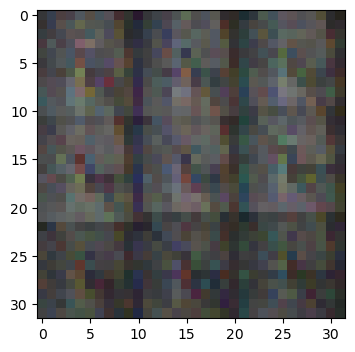

In [55]:
# Example of a picture

image = train_set_x_orig[index].reshape((32, 32, 3))
plt.imshow(image)
print("y = " + str(train_set_y_orig[0, index]) + " . It's a " + classes[train_set_y_orig[0, index]].decode("utf-8") + " picture.")
                                                                    

In [56]:
# Exploring dataset 

m_train = train_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
m_test = test_set_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x_orig shape: " + str(train_set_x_orig.shape))
print ("train_set_y_orig shape: " + str(train_set_y_orig.shape))
print ("test_set_x_orig shape: " + str(test_set_x_orig.shape))
print ("test_set_y_orig shape: " + str(test_set_y_orig.shape))

Number of training examples: 10000
Number of testing examples: 10000
Each image is of size: (3072, 3072, 3)
train_set_x_orig shape: (10000, 3072)
train_set_y_orig shape: (1, 10000)
test_set_x_orig shape: (10000, 3072)
test_set_y_orig shape: (1, 10000)


In [57]:
# Reshape the training and test examples 
train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_y_flatten = train_set_y_orig.reshape(train_set_y_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_y_flatten = test_set_y_orig.reshape(test_set_y_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

train_y = train_y_flatten/255.
test_y = test_y_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))



train_x's shape: (3072, 10000)
test_x's shape: (3072, 10000)
train_y's shape: (10000, 1)
test_y's shape: (10000, 1)


### Data Visualization

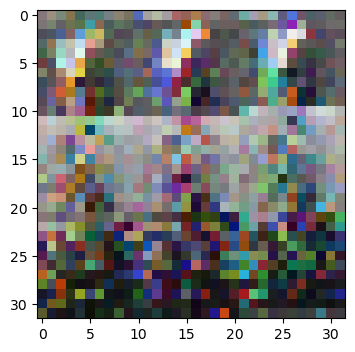

4


In [58]:
import matplotlib.pyplot as plt

i = 1005
image = train_set_x_orig[i].reshape(32, 32, 3)
plt.imshow(image, interpolation = 'nearest')
plt.show()
print(train_set_y_orig[0][i])

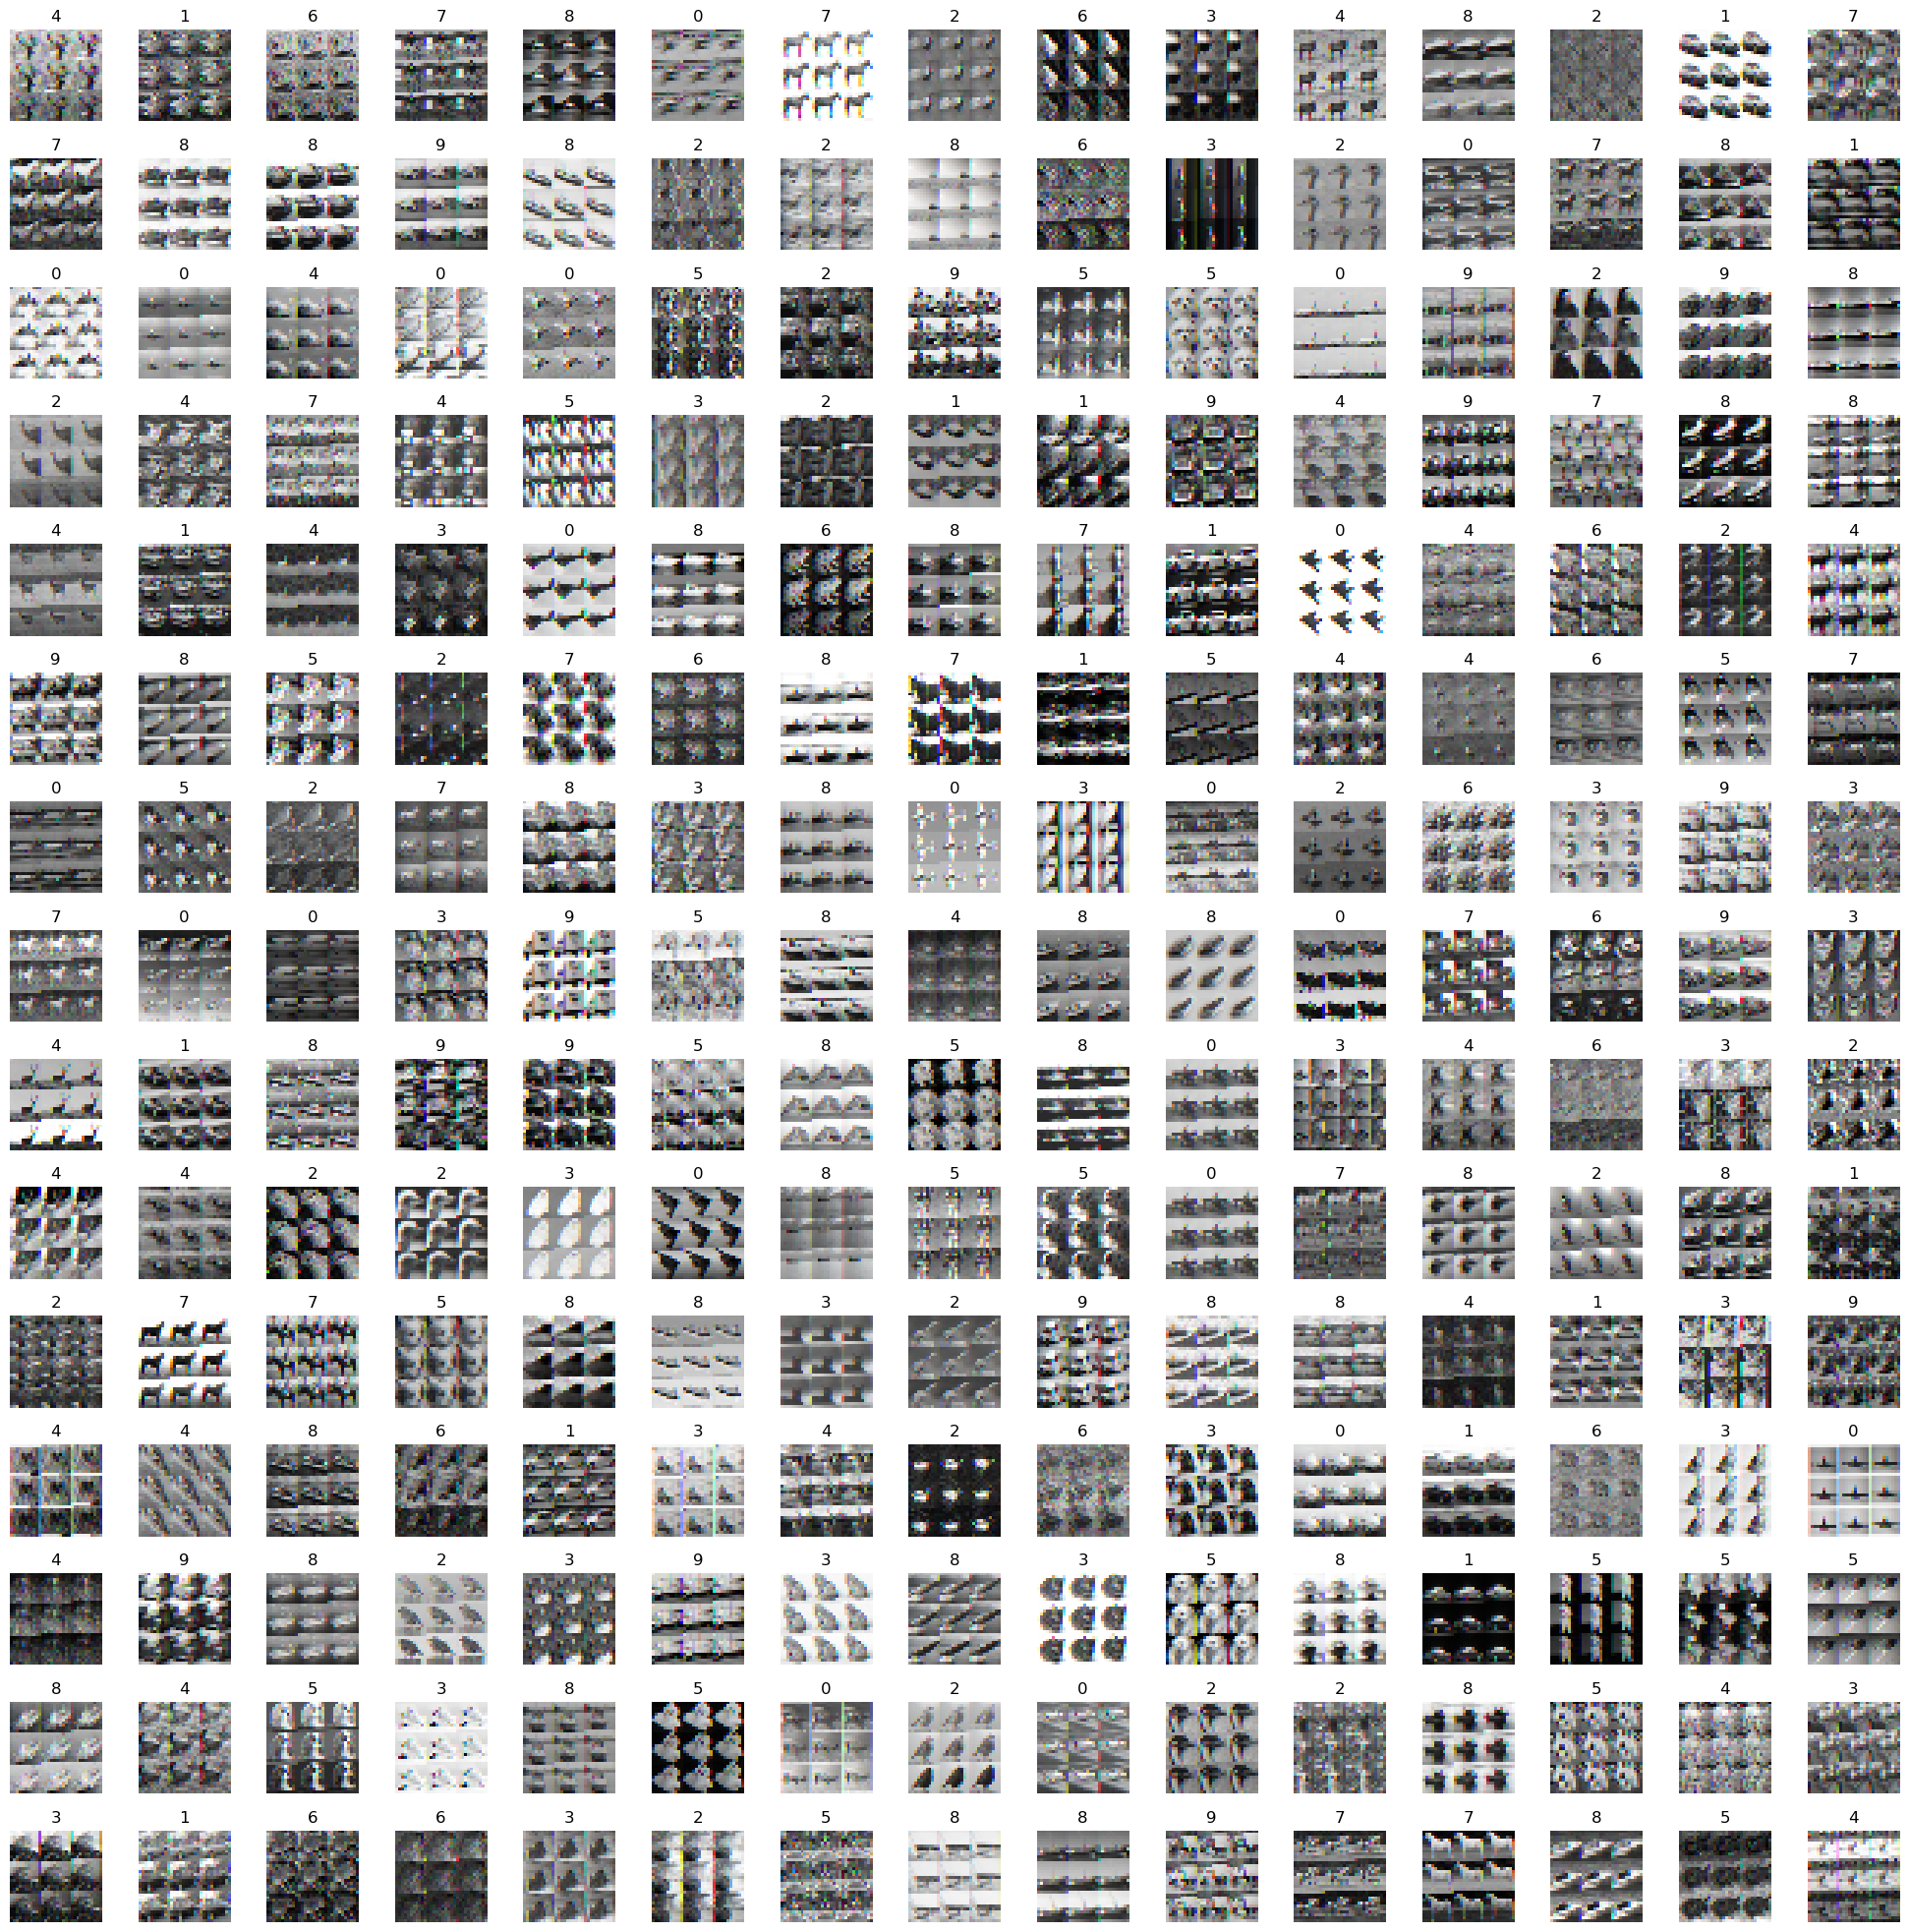

In [59]:
w_grid = 15
l_grid = 15
fig, axes = plt.subplots(l_grid, w_grid, figsize = (25, 25))
axes = axes.ravel()

for i in np.arange(0, l_grid * w_grid):
    index = np.random.randint(0, 10000)
    image = train_set_x_orig[index].reshape(32, 32, 3)
    axes[i].imshow(image)
    axes[i].set_title(str(train_set_y_orig[0, index]))
    axes[i].axis('off')
    
plt.subplots_adjust(hspace=0.4)
plt.show()

### Data Processing

In [60]:
train_set_x_orig = train_set_x_orig.astype('float32')
test_set_x_orig = test_set_x_orig.astype('float32')

In [61]:
def to_categorical(y, num_classes):
    n = y.shape[1]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    return categorical

num_classes = 10

train_set_y_orig_categorical = to_categorical(train_set_y_orig.T, num_classes)
test_set_y_orig_categorical = to_categorical(test_set_y_orig.T, num_classes)

In [62]:
train_set_x_orig = train_set_x_orig / 255
test_set_x_orig = test_set_x_orig / 255

In [63]:
train_set_x_orig[1]

array([0.6039216 , 0.49411765, 0.4117647 , ..., 0.54509807, 0.5568628 ,
       0.5647059 ], dtype=float32)

In [64]:
train_set_x_orig.shape

(10000, 3072)

In [65]:
Input_shape = train_set_x_orig.shape[1:]

In [66]:
Input_shape

(3072,)

In [67]:
train_set_y_orig.shape

(1, 10000)

### Training the model

In [68]:
import numpy as np

def relu(x, inplace=False):
    if inplace:
        np.maximum(x, 0, out=x)
        return x
    else:
        return np.maximum(x, 0)
#    assert(A.shape == Z.shape)
    
#    cache = Z
#    return A, cache

In [69]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis = 1, keepdims = True))
    return exp_Z / np.sum(exp_Z, axis =1 , keepdims = True)

In [70]:
def conv2d(x, filters, kernel_size):
    stride = 1 
    padding = 'valid'
    input_shape = x.shape
    num_samples, input_channels, input_height, input_width = input_shape
    num_filters, _, kernel_height, kernel_width = filters.shape
    
    output_height = (input_height - kernel_height) // stride + 1
    output_width = (input_width - kernel_width) // stride + 1
    output_shape = (num_samples, num_filters, output_height, output_width)
    output = np.zeros(output_shape)
    
    for s in range(num_samples):  # Loop over samples
        for i in range(output_height):
            for j in range(output_width):
                receptive_field = x[s, :, i:i + kernel_height, j:j + kernel_width]
                output[s, :, i, j] = np.sum(receptive_field * filters, axis=(1, 2, 3))
            
    return output


In [71]:
def max_pooling2d(x, pool_size):
    stride = pool_size
    input_shape = x.shape
    num_samples, input_channels, input_height, input_width = input_shape
    
    output_height = input_height // stride 
    output_width = input_width // stride
    output_shape = (num_samples, input_channels, output_height, output_width)
    output = np.zero(output_shape)
    
    for i in range(output_height):
        for j in range(output_width):
            receptive_field = x[:, :, i * stride:(i * stride + stride), j * stride:(j * stride + stride)]
            output[:, :, i, j] = np.max(receptive_field, axis=(2, 3))
            
    return output

In [72]:
def average_pooling2d(x, pool_size):
    stride = pool_size
    input_shape = x.shape
    num_samples, input_channels, input_height, input_width = x.shape
    
    output_height = input_height // stride 
    output_width = input_width // stride
    output_shape = (num_samples, input_channels, output_height, output_width)
    output = np.zeros(output_shape)
    
    for s in range(num_samples):
        for c in range(input_channels):
            for i in range(output_height):
                for j in range(output_width):
                    receptive_field = x[s, c, i * stride:(i + 1) * stride, j * stride:(j + 1) * stride]
                    output[s, c, i, j] = np.mean(receptive_field)

    return output

In [73]:
def dense(x, weights, biases):
    output = np.dot(x, weights) + biases
    return output

In [74]:
def dropout(x, rate):
    mask = np.random.binomial(1, rate, size = x.shape) / rate
    output = x * mask
    return output

In [75]:
# Define the model architecture
input_shape = (28, 28, 1)
cnn_model = []

# Convolutional layers
cnn_model.append({'weights': np.random.randn(3, 3, 1, 32), 'activation': relu})
cnn_model.append({'weights': np.random.randn(3, 3, 32, 32), 'activation': relu})
cnn_model.append({'pool_size': (2, 2)})
cnn_model.append({'dropout_rate': 0.2})
cnn_model.append({'weights': np.random.randn(3, 3, 32, 64), 'activation': relu})
cnn_model.append({'weights': np.random.randn(3, 3, 64, 64), 'activation': relu})
cnn_model.append({'pool_size': (2, 2)})
cnn_model.append({'dropout_rate': 0.3})

# Flatten layer
cnn_model.append({})

# Dense layers
cnn_model.append({'weights': np.random.randn(3136, 1024), 'bias': np.zeros((1024,)), 'activation': relu})
cnn_model.append({'weights': np.random.randn(1024, 1024), 'bias': np.zeros((1024,)), 'activation': relu})
cnn_model.append({'weights': np.random.randn(1024, 10), 'bias': np.zeros((10,)), 'activation': softmax})

# Forward pass
x = np.random.randn(28, 28, 1)
for layer in cnn_model:
    if 'weights' in layer:
        x = conv2d(x, layer['weights'], layer['weights'].shape[:2])
        x = layer['activation'](x)
    elif 'pool_size' in layer:
        x = average_pooling2d(x, layer['pool_size'])
    elif 'dropout_rate' in layer:
        x = dropout(x, layer['dropout_rate'])
    else:
        x = np.reshape(x, (x.shape[0] * x.shape[1] * x.shape[2],))
        x = dense(x, layer['weights'], layer['bias'])
        x = layer['activation'](x)

print(x)

### 4-Layer Neural Network

In [78]:
#CONSTANTS DEFINING THE MODEL

n_x = 3072     # num_px * num_px * 3
n_h1 = 7
n_h2 = 7
n_h3 = 7
n_y = 1
layers_dims = (n_x, n_h1, n_h2, n_h3, n_y)

In [79]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []    # to keep track of the cost
    m = X.shape[1]    # number of examples
    (n_x, n_h1, n_h2, n_h3, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h1, n_h2, n_h3, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    W4 = parameters["W4"]
    b4 = parameters["b4"]

    for i in range(0, num_iterations):

        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'relu')
        A3, cache3 = linear_activation_forward(A2, W3, b3, 'relu')
        A4, cache4 = linear_activation_forward(A3, W4, b4, 'sigmoid')
        
        cost = compute_cost(A4, Y)
                
        dA4 = - (np.divide(Y.T, A4) - np.divide(1 - Y.T, 1 - A4))
        
        dA3, dW4, db4 = linear_activation_backward(dA4, cache4, 'sigmoid')
        dA2, dW3, db3 = linear_activation_backward(dA3, cache3, 'relu')
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'relu')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        grads['dW3'] = dW3
        grads['db3'] = db3
        grads['dW4'] = dW4
        grads['db4'] = db4

        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        W3 = parameters["W3"]
        b3 = parameters["b3"]
        W4 = parameters["W4"]
        b4 = parameters["b4"]
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [80]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h1, n_h2, n_h3, n_y), num_iterations = 2500, print_cost=True)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7 but corresponding boolean dimension is 1

In [ ]:
prediction_train = predict(train_x, train_y, parameters)

In [ ]:
prediction_test = predict(test_x, test_y, parameters)

In [ ]:
parameters = two_layer_model(train_x, train_y, layer_dims = (n_x, n_h1, n_h2, n_h3, n_y), num_iterations = 1500, print_cost=True)

In [ ]:
predictions_train = predict(train_x, train_y, parameters)
predictions_test = predict(test_x, test_y, parameters)

### L-Layer Neural Network

In [ ]:
# CONSTANTS
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009

    np.random.seed(1)
    costs = []    # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dims)
     
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost
        cost = compute_cost(AL, Y)
    
        # Backward propagation
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [ ]:
pred_train = predict(train_x, train_y, parameters)

In [ ]:
pred_test = predict(test_x, test_y, parameters)

### Result Analysis

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)